In [4]:
%pylab inline
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from lightgbm import LGBMClassifier
import pandas as pd
from multiprocessing import Pool, cpu_count

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
np.warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

# PyTorch Version

In [6]:
import torch
print(torch.__version__)
# move to HPC, pytorch=1.6.0

0.4.0


# Import data

In [9]:
train_df = pd.read_csv('/Users/wh1165/Desktop/AIcrowd_Competition/NLP/input/train_set.csv', sep='\t')
test_df = pd.read_csv('/Users/wh1165/Desktop/AIcrowd_Competition/NLP/input/test_a.csv', sep='\t', nrows=None)

# Split Data 

devided into train set and validation set

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text'].iloc[:].values, train_df['label'].iloc[:].values,
    test_size=0.05, random_state=42
)

one-hot encoding for labels （Not needed for MLP）

In [12]:
# from sklearn.preprocessing import OneHotEncoder

# n=y_train.shape[0]
# m=y_val.shape[0]

# train_label = y_train.reshape(n,1)
# val_label = y_val.reshape(m,1)

# ohe = OneHotEncoder()
# ohe.fit([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13]])

# train_label_oh = ohe.transform(train_label).toarray()
# val_label_oh = ohe.transform(val_label).toarray()

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [ ]:
# one-hot, another method
# torch.nn.functional.one_hot(x)

convert one-hot output to standard output

In [32]:
# 例如
# int(np.matrix([0,1,0,0])*np.matrix([1,2,3,4]).T)

# Featurization

In [13]:
vectorizer = CountVectorizer(ngram_range=(1,3), max_df=0.9, max_features=20000)
vectorizer.fit(train_df['text'].iloc[:].values)

X_train_vec = vectorizer.transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(test_df['text'].iloc[:].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=20000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
print(X_train_vec.shape)
print(X_val_vec.shape)
print(X_test_vec.shape)

(190000, 20000)
(10000, 20000)
(50000, 20000)


Shuffle, can be done by PyTorh DataLoader

In [19]:
# shuffle_index = np.random.permutation(trainset.shape[0])   #shuffle the data
# train_s, label_s = trainset[shuffle_index], train_df['label'].iloc[:].values[shuffle_index]

CountVectorizer to Dense matrix.

In [92]:
# CountVectorizer has given sparse matrix,
X_train_tensor = torch.from_numpy(X_train_vec.todense()).float()
X_val_tensor = torch.from_numpy(X_val_vec.todense()).float()
X_test_tensor = torch.from_numpy(X_test_vec.todense()).float()

# y_train_tensor = train_label_oh
# y_val_tensor = val_label_oh

y_train_tensor = torch.from_numpy(np.array(y_train))
y_val_tensor = torch.from_numpy(np.array(y_val))

# X_train, y_train, X_val, y_val = map(
#     torch.tensor, (X_train, y_train, X_val, y_val)
# )

# Build deep MLP model

In [103]:
from torch import nn
import torch.nn.functional as F

loss_func = F.cross_entropy ## specify loss function

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20000, 500) ## n_hidden1
        self.fc2 = nn.Linear(500, 100) ## n_hidden2
        self.fc3 = nn.Linear(100, 14)

    def forward(self, x):
        x = x.view(-1, 20000)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [111]:
def accuracy(out, y_real):
    y_pred = torch.argmax(out, dim=1)
    return (y_pred == y_real).float().mean()

In [104]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim

lr = 0.01  # learning rate
epochs = 20  # how many epochs to train for
bs = 50

# Use DataLoader class for batching but it requires TensorDataset
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
#create batches
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

def get_model():
    model = MLP()
    return model, optim.SGD(model.parameters(), lr=lr)

In [105]:
valid_ds = TensorDataset(X_val_tensor, y_val_tensor)
valid_dl = DataLoader(valid_ds, batch_size=bs)

# Check the random Model

In [112]:
model = MLP()
print(loss_func(model(X_train_tensor), y_train_tensor), accuracy(model(X_train_tensor), y_train_tensor))

tensor(2.6333) tensor(1.00000e-02 *
       5.3837)


In [114]:
print(loss_func(model(X_val_tensor), y_val_tensor), accuracy(model(X_val_tensor), y_val_tensor))

tensor(2.6316) tensor(1.00000e-02 *
       5.3200)


# Define EarlyStopping

In [115]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(self.val_loss_min,
                                                                                            val_loss))
        torch.save(model.state_dict(), '/Users/wh1165/Desktop/AIcrowd_Competition/NLP/model/MLP1_checkpoint.pt')
        self.val_loss_min = val_loss

# Train the MLP model

In [118]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=30, verbose=True)

model, opt = get_model()
epochs = 10001

for epoch in range(epochs):
    model.train() 
    for batch, (xb, yb) in enumerate(train_dl, 1):
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_losses.append(loss.item())
    
    model.eval()
    for xb, yb in valid_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        valid_losses.append(loss.item())
        
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    print_msg = ('epoch:{} '.format(epoch+1) +
                 'train_loss: {:.5f} '.format(train_loss) +
                 'valid_loss: {:.5f}'.format(valid_loss))
    print(print_msg)
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:1 train_loss: 0.84996 valid_loss: 0.37274
Validation loss decreased (inf --> 0.372742).  Saving model ...


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:2 train_loss: 0.58178 valid_loss: 0.32240
Validation loss decreased (0.372742 --> 0.322402).  Saving model ...


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:3 train_loss: 0.38190 valid_loss: 0.27307
Validation loss decreased (0.322402 --> 0.273069).  Saving model ...


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:4 train_loss: 0.38948 valid_loss: 0.63472
EarlyStopping counter: 1 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:5 train_loss: 4.78845 valid_loss: 0.31057
EarlyStopping counter: 2 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:6 train_loss: 2.47536 valid_loss: 0.37892
EarlyStopping counter: 3 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:7 train_loss: 1.02595 valid_loss: 0.29310
EarlyStopping counter: 4 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:8 train_loss: 0.40783 valid_loss: 0.39528
EarlyStopping counter: 5 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:9 train_loss: 0.84185 valid_loss: 0.28335
EarlyStopping counter: 6 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:10 train_loss: 0.26028 valid_loss: 0.39828
EarlyStopping counter: 7 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:11 train_loss: 1.53593 valid_loss: 0.28658
EarlyStopping counter: 8 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:12 train_loss: 0.52374 valid_loss: 0.32490
EarlyStopping counter: 9 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:13 train_loss: 0.32626 valid_loss: 0.26283
Validation loss decreased (0.273069 --> 0.262834).  Saving model ...


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:14 train_loss: 0.26653 valid_loss: 0.27177
EarlyStopping counter: 1 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:15 train_loss: 0.24653 valid_loss: 0.23597
Validation loss decreased (0.262834 --> 0.235971).  Saving model ...


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:16 train_loss: 0.32094 valid_loss: 0.26456
EarlyStopping counter: 1 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:17 train_loss: 0.28636 valid_loss: 0.27105
EarlyStopping counter: 2 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:18 train_loss: 0.23444 valid_loss: 0.24920
EarlyStopping counter: 3 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:19 train_loss: 1.51262 valid_loss: 0.27932
EarlyStopping counter: 4 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:20 train_loss: 0.29912 valid_loss: 0.25585
EarlyStopping counter: 5 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:21 train_loss: 0.26613 valid_loss: 0.48833
EarlyStopping counter: 6 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:22 train_loss: 0.42630 valid_loss: 0.27646
EarlyStopping counter: 7 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:23 train_loss: 0.65465 valid_loss: 0.33345
EarlyStopping counter: 8 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:24 train_loss: 0.24081 valid_loss: 0.33088
EarlyStopping counter: 9 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:25 train_loss: 0.42251 valid_loss: 0.32755
EarlyStopping counter: 10 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:26 train_loss: 0.28365 valid_loss: 0.52079
EarlyStopping counter: 11 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:27 train_loss: 0.28928 valid_loss: 0.30728
EarlyStopping counter: 12 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:28 train_loss: 3.04415 valid_loss: 2.02747
EarlyStopping counter: 13 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:29 train_loss: 0.59912 valid_loss: 0.25200
EarlyStopping counter: 14 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:30 train_loss: 0.38822 valid_loss: 0.24800
EarlyStopping counter: 15 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:31 train_loss: 0.39739 valid_loss: 0.26100
EarlyStopping counter: 16 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:32 train_loss: 1.04829 valid_loss: 0.25260
EarlyStopping counter: 17 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:33 train_loss: 0.38232 valid_loss: 0.35790
EarlyStopping counter: 18 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:34 train_loss: 0.39267 valid_loss: 0.40562
EarlyStopping counter: 19 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:35 train_loss: 0.42933 valid_loss: 0.27395
EarlyStopping counter: 20 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:36 train_loss: 0.44440 valid_loss: 0.28474
EarlyStopping counter: 21 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:37 train_loss: 0.22979 valid_loss: 0.25816
EarlyStopping counter: 22 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:38 train_loss: 0.37456 valid_loss: 0.37666
EarlyStopping counter: 23 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:39 train_loss: 0.44371 valid_loss: 0.23890
EarlyStopping counter: 24 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:40 train_loss: 0.39730 valid_loss: 0.50344
EarlyStopping counter: 25 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:41 train_loss: 0.18791 valid_loss: 0.23039
Validation loss decreased (0.235971 --> 0.230388).  Saving model ...


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:42 train_loss: 0.15062 valid_loss: 0.30906
EarlyStopping counter: 1 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:43 train_loss: 0.19482 valid_loss: 0.24199
EarlyStopping counter: 2 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:44 train_loss: 0.36141 valid_loss: 0.22594
Validation loss decreased (0.230388 --> 0.225938).  Saving model ...


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:45 train_loss: 0.21615 valid_loss: 0.24187
EarlyStopping counter: 1 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:46 train_loss: 0.24003 valid_loss: 0.24373
EarlyStopping counter: 2 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:47 train_loss: 0.27845 valid_loss: 0.26046
EarlyStopping counter: 3 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:48 train_loss: 0.45522 valid_loss: 0.28461
EarlyStopping counter: 4 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:49 train_loss: 0.25743 valid_loss: 0.25838
EarlyStopping counter: 5 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:50 train_loss: 0.17259 valid_loss: 0.25036
EarlyStopping counter: 6 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:51 train_loss: 0.28879 valid_loss: 0.23573
EarlyStopping counter: 7 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:52 train_loss: 0.71505 valid_loss: 0.25900
EarlyStopping counter: 8 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:53 train_loss: 0.47440 valid_loss: 0.26477
EarlyStopping counter: 9 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:54 train_loss: 0.24052 valid_loss: 0.24507
EarlyStopping counter: 10 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:55 train_loss: 0.15707 valid_loss: 0.29744
EarlyStopping counter: 11 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:56 train_loss: 0.15316 valid_loss: 0.23743
EarlyStopping counter: 12 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:57 train_loss: 0.29845 valid_loss: 0.25761
EarlyStopping counter: 13 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:58 train_loss: 0.39376 valid_loss: 0.29601
EarlyStopping counter: 14 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:59 train_loss: 0.45048 valid_loss: 0.26899
EarlyStopping counter: 15 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:60 train_loss: 0.31353 valid_loss: 0.35259
EarlyStopping counter: 16 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:61 train_loss: 0.58735 valid_loss: 0.25989
EarlyStopping counter: 17 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:62 train_loss: 0.23762 valid_loss: 0.28470
EarlyStopping counter: 18 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:63 train_loss: 0.15772 valid_loss: 0.30303
EarlyStopping counter: 19 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:64 train_loss: 0.30717 valid_loss: 0.34052
EarlyStopping counter: 20 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:65 train_loss: 0.46035 valid_loss: 0.29840
EarlyStopping counter: 21 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:66 train_loss: 0.18897 valid_loss: 0.24906
EarlyStopping counter: 22 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:67 train_loss: 0.50128 valid_loss: 0.36031
EarlyStopping counter: 23 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:68 train_loss: 0.38985 valid_loss: 0.36107
EarlyStopping counter: 24 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:69 train_loss: 0.54918 valid_loss: 0.26760
EarlyStopping counter: 25 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:70 train_loss: 0.15828 valid_loss: 0.32598
EarlyStopping counter: 26 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:71 train_loss: 0.15110 valid_loss: 0.56475
EarlyStopping counter: 27 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:72 train_loss: 0.69375 valid_loss: 0.27569
EarlyStopping counter: 28 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:73 train_loss: 0.17985 valid_loss: 0.25063
EarlyStopping counter: 29 out of 30


MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

epoch:74 train_loss: 0.28389 valid_loss: 0.44347
EarlyStopping counter: 30 out of 30
Early stopping


# Visualize the loss and earlystop

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'loss')

(0, 75)

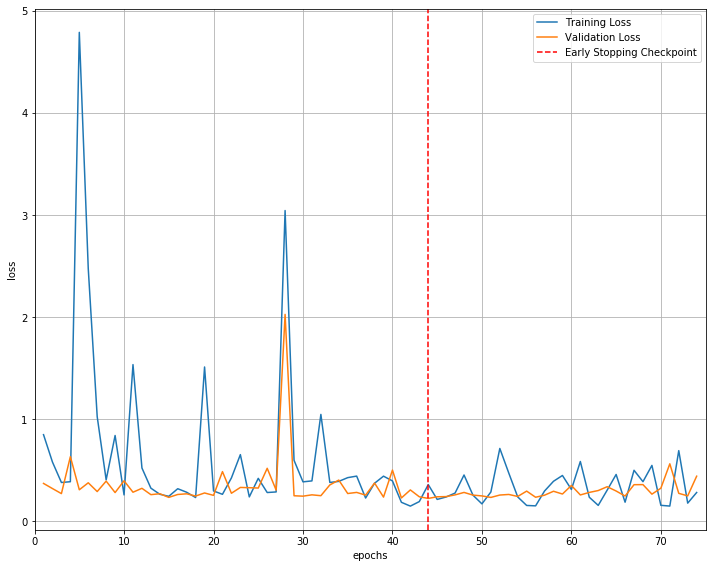

In [120]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Test performace

In [121]:
model.eval()
print('Test Accuracy: ', accuracy(model(X_val_tensor), y_val_tensor))

MLP(
  (fc1): Linear(in_features=20000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=14, bias=True)
)

Test Accuracy:  tensor(0.9331)


# Output

In [143]:
output_test = model(X_test_tensor)

find the best

In [144]:
f = output_test.detach().numpy()
ff = argmax(f,axis=1)

In [145]:
df = pd.DataFrame()
df['label'] = ff
df.to_csv('/Users/wh1165/Desktop/AIcrowd_Competition/NLP/input/submit_MLP1.csv', index=None)

# Save Model

In [146]:
torch.save(model, '/Users/wh1165/Desktop/AIcrowd_Competition/NLP/model/MLP1.pt')
#model = torch.load('model.pt')